In [1]:
# pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
import category_encoders as ce

## Original data

### EDA

In [2]:
sns.set_theme(style="white")
sns.set_palette("deep")

In [3]:
df_insurance = pd.read_csv("..\\..\\data\\insurance.csv")
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df_insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df_insurance.duplicated().sum()

1

In [7]:
idx = df_insurance[df_insurance.duplicated()].index
df_insurance.loc[idx]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [8]:
df_insurance[df_insurance.eq(df_insurance.loc[581]).all(axis=1)].index.tolist()

[195, 581]

In [9]:
df_insurance.loc[[195]]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631


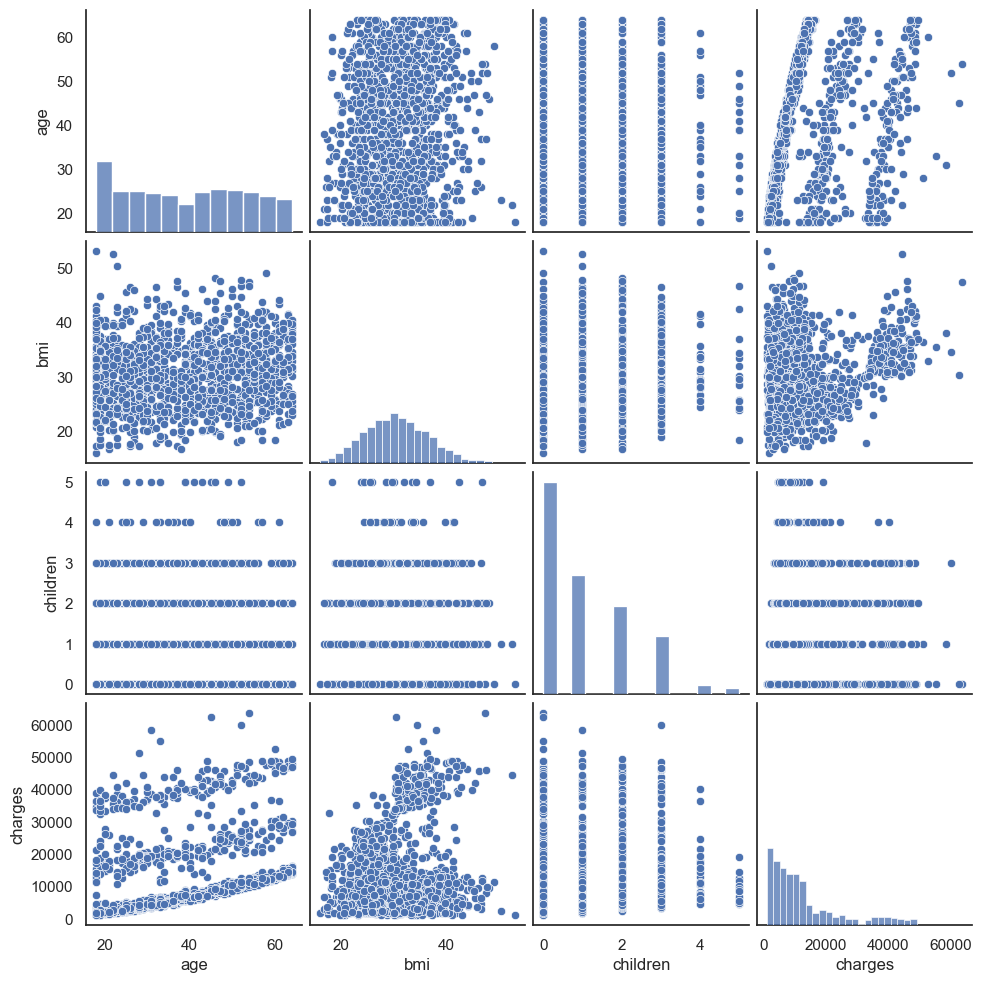

In [10]:
sns.pairplot(data=df_insurance)

In [11]:
df_insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [12]:
for el in df_insurance.columns:
    print(f"{el}: {df_insurance[el].unique().shape[0]}")

age: 47
sex: 2
bmi: 548
children: 6
smoker: 2
region: 4
charges: 1337


In [13]:
cat_col = ['sex', 'children', 'smoker', 'region']
non_cat_col = ['age', 'bmi', 'charges']

In [14]:
col_num = 3
rows_number = int(len(non_cat_col)/col_num)+1

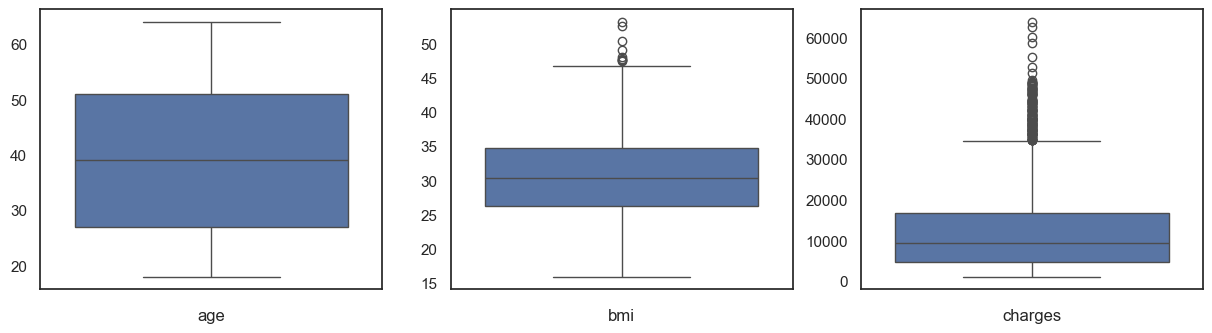

In [15]:
fig, ax = plt.subplots(rows_number, col_num, figsize=(col_num*5, rows_number*4))
for i in range(len(non_cat_col), rows_number*col_num):
    fig.delaxes(ax[rows_number-1, i%col_num])
for i in range(len(non_cat_col)):
    sns.boxplot(df_insurance[non_cat_col[i]], ax=ax[int(i/col_num),i%col_num])
    ax[int(i/col_num),i%col_num].set_xlabel(non_cat_col[i])
    ax[int(i/col_num),i%col_num].set_ylabel("")
plt.show()

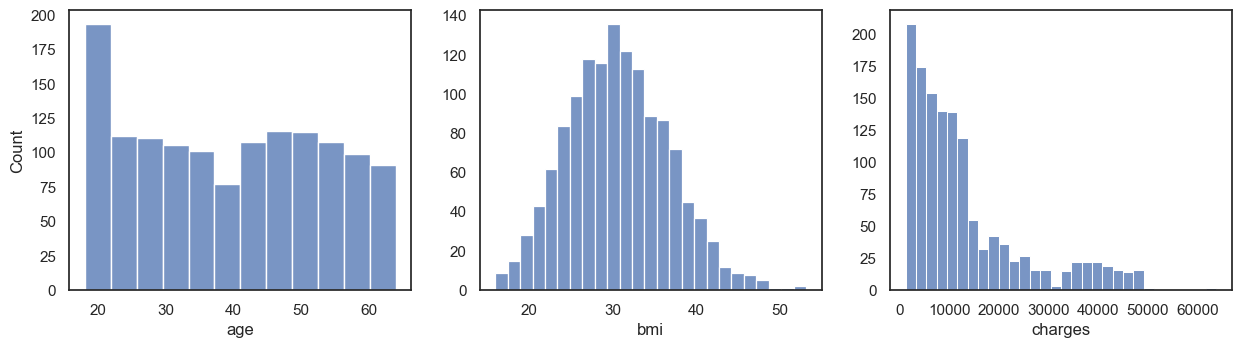

In [16]:
fig, ax = plt.subplots(rows_number, col_num, figsize=(col_num*5, rows_number*4))
for i in range(len(non_cat_col), rows_number*col_num):
    fig.delaxes(ax[rows_number-1, i%col_num])
for i in range(len(non_cat_col)):
    sns.histplot(df_insurance[non_cat_col[i]], ax=ax[int(i/col_num),i%col_num])
    if i % col_num != 0:  # If not the first column in the row, remove y-axis labels
        ax[int(i/col_num),i%col_num].set_ylabel("")
plt.show()

<Axes: xlabel='charges', ylabel='Count'>

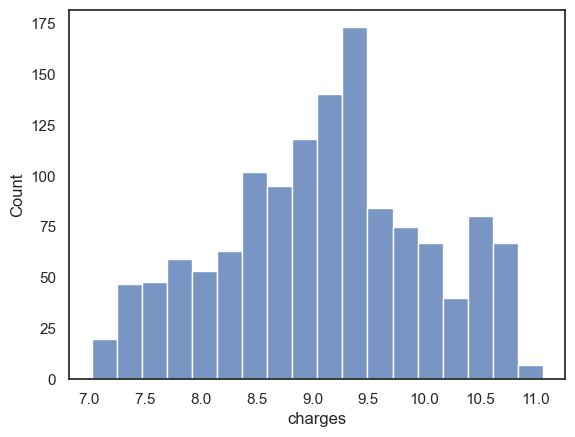

In [17]:
sns.histplot(np.log(df_insurance["charges"]))

In [18]:
df_insurance_enc = df_insurance.copy()
for el in cat_col:
    if el in df_insurance.select_dtypes(include=['object', 'category']):
        df_insurance_enc[el] = df_insurance[el].astype('category').cat.codes.replace(-1, np.nan)

<Axes: >

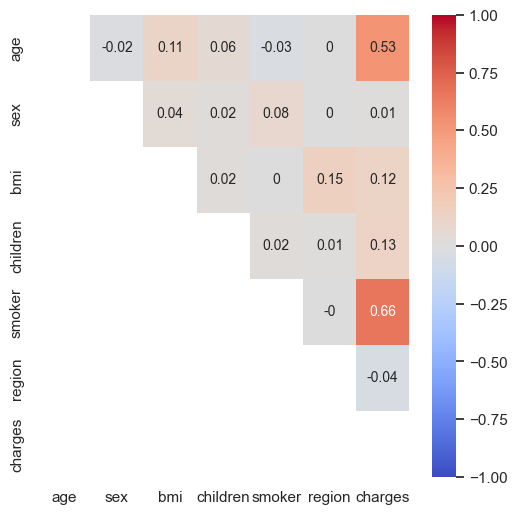

In [19]:
plt.figure(figsize = (6,6))
sns.heatmap(round(df_insurance_enc.corr(method = 'spearman'),2), mask = np.tril(df_insurance_enc.corr(method = 'spearman')), vmax=1, vmin=-1, 
            center=0,cmap='coolwarm', annot=True, annot_kws={"size": 10})

<Axes: xlabel='charges', ylabel='Percent'>

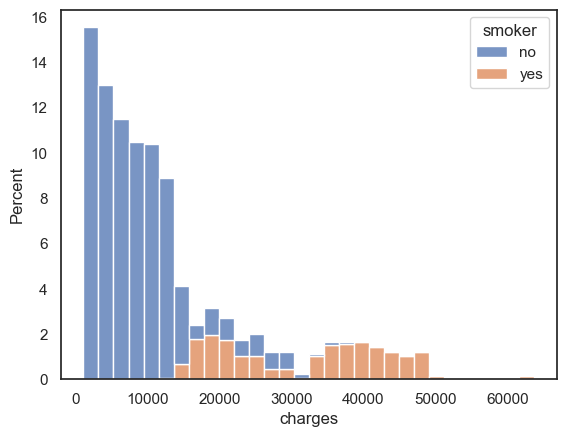

In [20]:
sns.histplot(data=df_insurance, x="charges", hue="smoker", multiple="stack", stat="percent", palette="deep", hue_order=["no", "yes"])

### DT feature importances

In [21]:
model = tree.DecisionTreeRegressor(random_state=42)
indep_col = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
dep_col = 'charges'

x_train = df_insurance_enc.loc[:, indep_col]
y_train = df_insurance_enc[[dep_col]]
model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [22]:
# feature importance
dict(zip(indep_col, model.feature_importances_))

{'age': 0.12768004388590698,
 'sex': 0.006296753861504389,
 'bmi': 0.21176860348348076,
 'children': 0.022297651151624055,
 'smoker': 0.6205919670174439,
 'region': 0.011364980600039794}

### Constraints & Conditions

In [23]:
# class balance
for el in cat_col:
    print(df_insurance[[el]].value_counts()/len(df_insurance))

sex   
male      0.505232
female    0.494768
Name: count, dtype: float64
children
0           0.428999
1           0.242152
2           0.179372
3           0.117339
4           0.018685
5           0.013453
Name: count, dtype: float64
smoker
no        0.795217
yes       0.204783
Name: count, dtype: float64
region   
southeast    0.272048
northwest    0.242900
southwest    0.242900
northeast    0.242152
Name: count, dtype: float64


<Axes: xlabel='children', ylabel='count'>

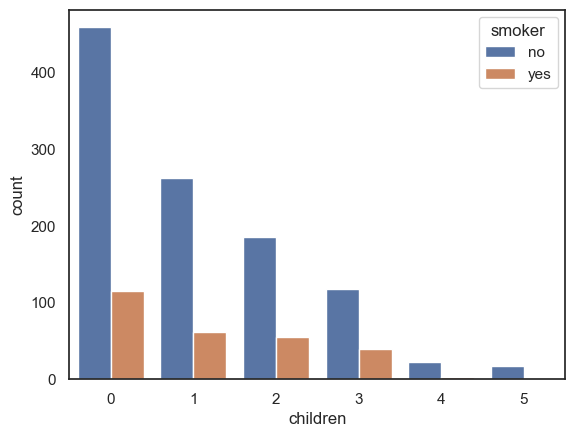

In [24]:
# condition
sns.countplot(data=df_insurance, x="children", hue="smoker", palette="deep", hue_order=["no", "yes"])

In [25]:
indicator = (df_insurance["children"] == 0) & (df_insurance["smoker"] == "no")
count = indicator.sum()
count/len(df_insurance)

0.3430493273542601

### Model parameters

In [26]:
categorical_cols = ['sex', 'children', 'smoker', 'region']
general_cols = ['age']
continuous_cols = ['bmi', 'charges']
mixed_cols = []
components_numbers = {'bmi': 5, 'charges': 12}
mixed_modes = {}
log_transf = []

class_balance = {"smoker": [0.5,0.5]} # constraint
condition_list = [{"col1":"smoker", "cat1": "no", "col2": "children", "cat2":0}]
cond_ratio = 0.5

target_col = "charges"
data_name = "insurance"
task = "regr"

## Generated data

### EDA

In [27]:
df_insurance_fake = pd.read_csv("..\\..\\results\\insurance\\synth_data\\constr_loss.csv",sep=',')
df_insurance_fake.head()

,age,sex,bmi,children,smoker,region,charges
0,50,male,35.39,1,no,southeast,14856.0650
1,18,female,30.39,0,no,southeast,6837.4582
2,42,female,32.37,5,no,northeast,10247.5863
3,56,male,30.77,1,no,northeast,13603.5347
4,52,male,40.48,2,yes,northeast,46809.9030


In [28]:
df_insurance_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   sex       700 non-null    object 
 2   bmi       700 non-null    float64
 3   children  700 non-null    int64  
 4   smoker    700 non-null    object 
 5   region    700 non-null    object 
 6   charges   700 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 38.4+ KB


In [29]:
df_insurance_fake.describe()

,age,bmi,children,charges
count,700.000000,700.000000,700.000000,700.000000
mean,39.391429,33.427143,1.081429,16549.280174
std,14.059182,5.198647,1.254667,12693.314097
min,18.000000,20.000000,0.000000,3116.405000
25%,25.000000,29.505000,0.000000,6766.871725
50%,43.000000,32.575000,1.000000,12538.586600
75%,52.000000,37.260000,2.000000,22110.282675
max,63.000000,49.630000,5.000000,54983.549200


In [30]:
df_insurance_fake.duplicated().sum()

0

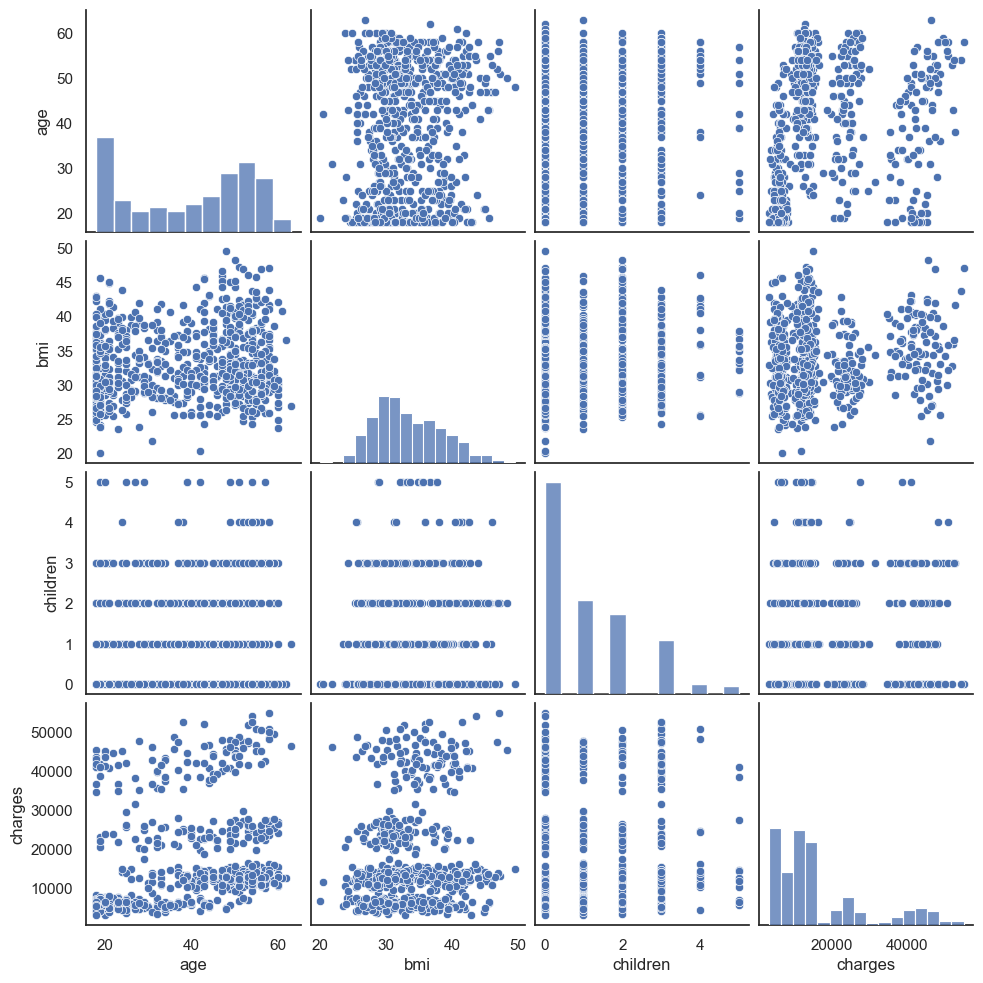

In [31]:
sns.pairplot(data=df_insurance_fake)

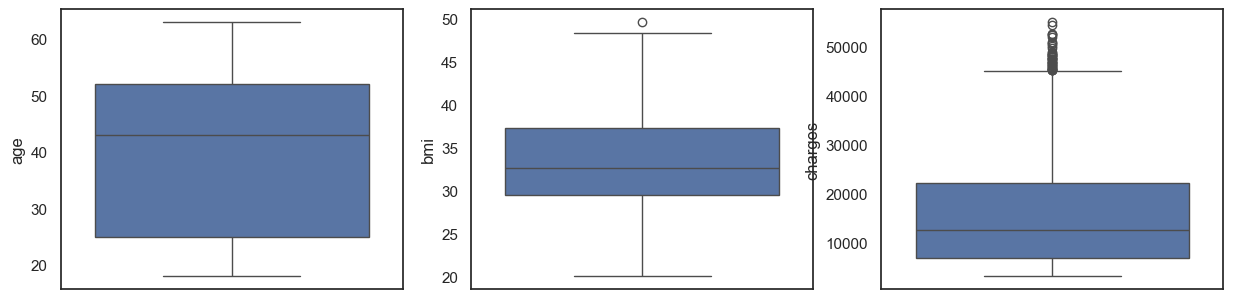

In [32]:
fig, ax = plt.subplots(rows_number, col_num, figsize=(col_num*5, rows_number*4))
for i in range(len(non_cat_col), rows_number*col_num):
    fig.delaxes(ax[rows_number-1, i%col_num])
for i in range(len(non_cat_col)):
    sns.boxplot(df_insurance_fake[non_cat_col[i]], ax=ax[int(i/col_num),i%col_num])
plt.show()

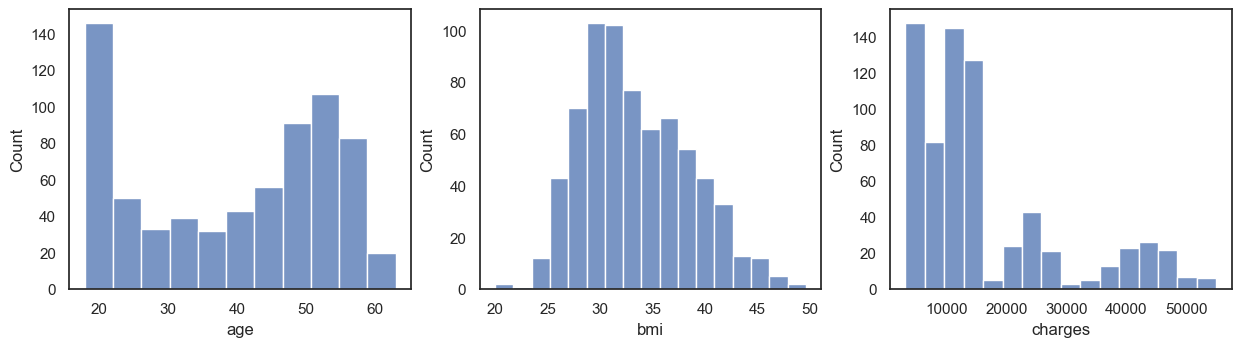

In [33]:
fig, ax = plt.subplots(rows_number, col_num, figsize=(col_num*5, rows_number*4))
for i in range(len(non_cat_col), rows_number*col_num):
    fig.delaxes(ax[rows_number-1, i%col_num])
for i in range(len(non_cat_col)):
    sns.histplot(df_insurance_fake[non_cat_col[i]], ax=ax[int(i/col_num),i%col_num])
plt.show()

In [34]:
df_insurance_fake_enc = df_insurance_fake.copy()

for el in cat_col:
    if el in df_insurance.select_dtypes(include=['object', 'category']):
        df_insurance_fake_enc[el] = df_insurance_fake[el].astype('category').cat.codes.replace(-1, np.nan)

<Axes: >

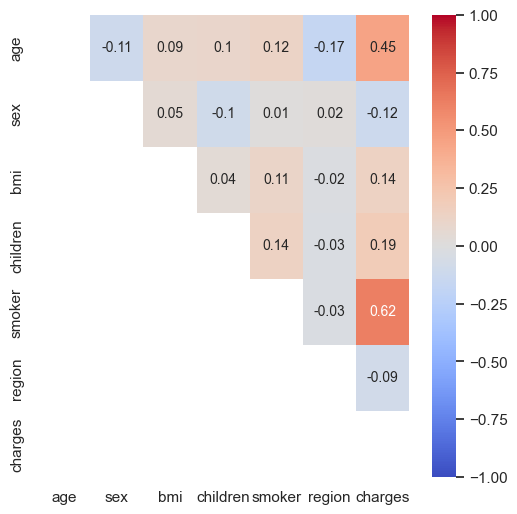

In [35]:
plt.figure(figsize = (6,6))
sns.heatmap(round(df_insurance_fake_enc.corr(method = 'spearman'),2), mask = np.tril(df_insurance_fake_enc.corr(method = 'spearman')), vmax=1, vmin=-1, 
            center=0,cmap='coolwarm', annot=True, annot_kws={"size": 10})

<Axes: xlabel='charges', ylabel='Percent'>

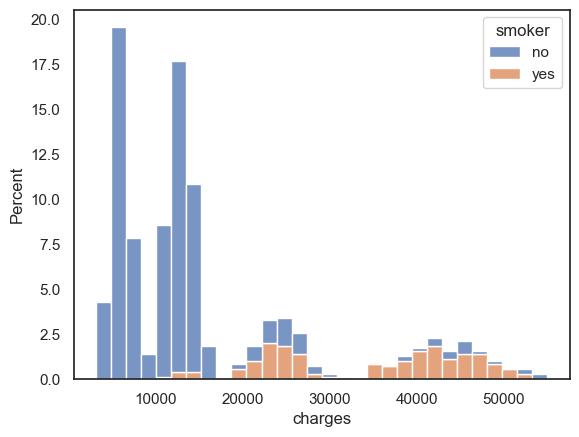

In [36]:
sns.histplot(data=df_insurance_fake, x="charges", hue="smoker", multiple="stack", stat="percent", palette="deep", hue_order=["no", "yes"], bins=30)

### Constraints & Conditions

In [37]:
# class balance
for el in cat_col:
    print(df_insurance_fake[[el]].value_counts()/len(df_insurance_fake))

sex   
female    0.535714
male      0.464286
Name: count, dtype: float64
children
0           0.462857
1           0.205714
2           0.174286
3           0.118571
4           0.021429
5           0.017143
Name: count, dtype: float64
smoker
no        0.797143
yes       0.202857
Name: count, dtype: float64
region   
southeast    0.320000
northeast    0.257143
southwest    0.234286
northwest    0.188571
Name: count, dtype: float64


<Axes: xlabel='children', ylabel='count'>

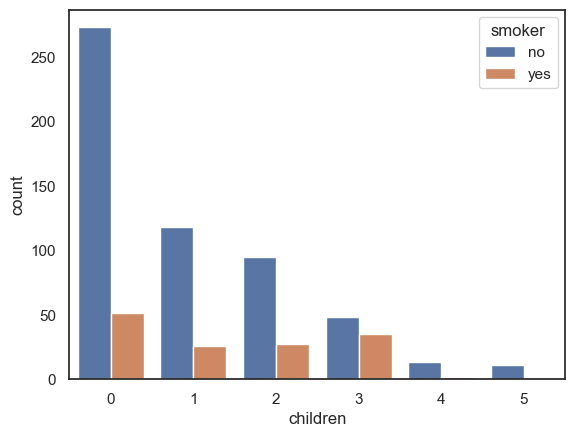

In [38]:
# condition
sns.countplot(data=df_insurance_fake, x="children", hue="smoker", palette="deep")

In [39]:
indicator = (df_insurance_fake["children"] == 0) & (df_insurance_fake["smoker"] == "no")
count = indicator.sum()
count/len(df_insurance_fake)

0.39

## Merged

In [40]:
df_insurance_m = df_insurance.copy()
df_insurance_fake_m = df_insurance_fake.copy()

In [41]:
df_insurance_m = df_insurance_m.sample(len(df_insurance_fake_m))

In [42]:
df_insurance_m["data"] = "real"
df_insurance_fake_m["data"] = "fake"

In [43]:
df_merged = pd.concat([df_insurance_m,  df_insurance_fake_m],ignore_index=True)

In [44]:
df_merged.duplicated().sum()

1

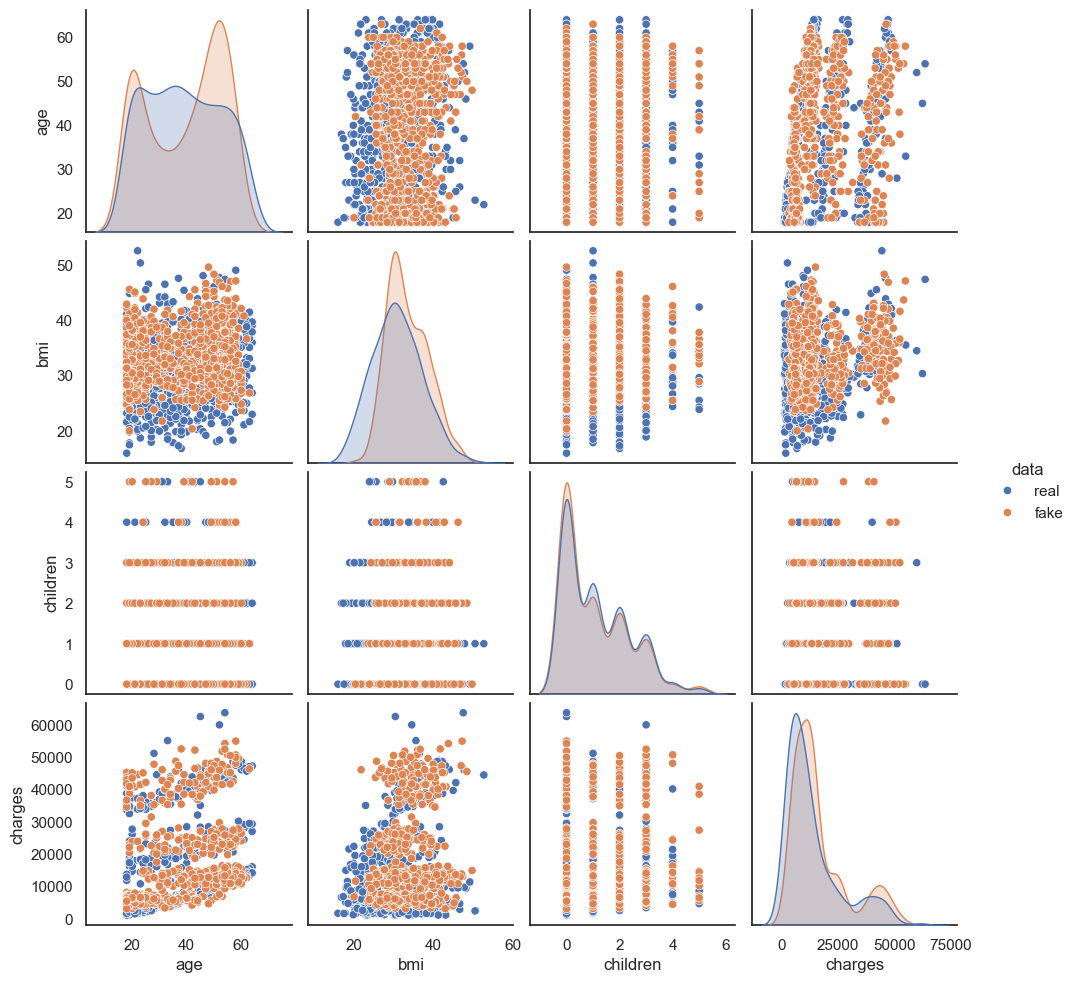

In [45]:
sns.pairplot(df_merged, hue="data")

In [46]:
!jupyter nbconvert --to html --no-input insurance.ipynb

[NbConvertApp] Converting notebook insurance.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 1830673 bytes to insurance.html
